## Integrantes

- **Estudiante 1:** Juan David Duarte Yara - 202215070
- **Estudiante 2:** Luisa Gabriela Hernández Pérez - 202114093
- **Estudiante 3:** Juan Sebastian Sanchez - 202121498
- Todos los estudiantes aportaron en las partes generales del notebook y en las diapositivas de coclusiones.



## 0. Carga de los datos. 

### 0.1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [195]:
# Importaciones de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
import re
import string
import unicodedata

# Importaciones de joblib
from joblib import dump, load

# Importaciones de sklearn
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Importaciones de statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Importaciones de nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer

# Instalación de paquetes adicionales
import contractions

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Para la validación cruzada
from sklearn.model_selection import KFold

### 0.2. Lectura de archivos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv (archivo separado por comas).

In [196]:
# Se cargan los datos. 
datatrain=pd.read_csv('fake_news_spanish.csv', sep=';', encoding = 'utf-8')#, nrows=500)
datatest = pd.read_csv('fake_news_test.csv', sep=';', encoding = 'utf-8')

Podemos ver que hay 57,063 filas y 5 columnas de atributos en el conjunto de entrenamiento

In [197]:
datatrain.shape

(57063, 5)

Podemos ver que hay 1000 filas y 4 columnas de atributos en el conjunto de prueba

In [198]:
datatest.shape

(1000, 4)

Veamos un pequeño sample de los datos

In [199]:
datatrain.sample(10)

,ID,Label,Titulo,Descripcion,Fecha
9060,ID,1,Quiénes van a la manifestación: de Corcuera a ...,"Hogar Social, el exministro Corcuera, el colec...",10/02/2019
27571,ID,0,Las diferencias entre EAJ-PNV y Sumar llegan h...,"El jefe de gabinete de Díaz, Josep Vendrell, y...",27/03/2023
25895,ID,1,"Más País no llega al 5% en intención de voto, ...","El barómetro de La Sexta destaca que el 75,3% ...",06/10/2019
20156,ID,0,Page dice que la censura parental de Coalición...,El presidente castellano-manchego asegura que ...,17/02/2020
51431,ID,1,"Odón Elorza, el diputado del PSOE crítico con ...","El parlamentario socialista, ex alcalde de San...",15/04/2022
14586,ID,0,Continúa el pulso de los partidos en Por Andal...,"La Mesa del Parlamento recibe dos escritos, un...",14/09/2022
24436,ID,0,El EQUO denuncia dos ataques contra sus sedes ...,Algunas sedes socialistas han amanecido con su...,25/05/2020
54259,ID,1,El juez abre juicio oral al expresidente de la...,El magistrado considera que se produjo una con...,24/02/2021
35648,ID,1,Sánchez no cede y rechaza una última oferta de...,El Gobierno asegura que sigue sin tener todas ...,23/11/2018
36923,ID,1,España ofrece acoger a barco con inmigrantes r...,España ofrece acoger a barco con inmigrantes r...,14/10/2016


Revisemos que el tipo de dato sea el esperado

In [200]:
datatrain.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [201]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


---


# 2. Entendimiento de los datos

## 2.1 Analisis descriptivo

Podemos ver que hay textos repetidos

In [202]:
datatrain["Descripcion"].describe()


count                                                 57063
unique                                                49638
top       La Fundación En Acción ha participado con Públ...
freq                                                      7
Name: Descripcion, dtype: object

Es útil saber que tan largos son los textos

In [203]:
datatrain["Descripcion"].apply(len).describe()

count    57063.000000
mean       243.519724
std        274.479568
min         33.000000
25%        171.000000
50%        221.000000
75%        267.000000
max      14153.000000
Name: Descripcion, dtype: float64

Los textos tienen una longitud entre 33 y 14,153 caracteres, con una media de 243 caracteres. 

Queremos ver ahora la columna "label"

In [204]:
datatrain["Label"].describe()

count    57063.000000
mean         0.581077
std          0.493387
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

Podemos ver que efectivamente la columna "Label" tiene valores entre 0 y 1.

Nos gustaría saber la proporción que hay entre noticias falsas y las que no

In [205]:
datatrain["Label"].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

Podemos ver que los datos están ligeramente desbalanceados

In [206]:
datatrain.head(2)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023


In [207]:
datatrain[["Titulo", "Descripcion"]].head(2)

,Titulo,Descripcion
0,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...


Estadisticas de cada registro del tamaño del texto concatenado entre 
- *Conteo total:* titulo + descripcion
- *Conteo titulo:* titulo 
- *Conteo descripcion:*  descripcion
- *Min* : palabra mas corta de cada registro
- *Max* : palabra mas larga de cada registro


In [208]:
textos = datatrain.copy()
textos["Message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)

textos["Conteo total"] = textos["Message"].str.len()
textos["Conteo titulo"] = textos["Titulo"].str.len()
textos["Conteo descripcion"] = textos["Descripcion"].str.len()

textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

textos[["Conteo total", "Conteo titulo", "Conteo descripcion", "Max", "Min"]].describe()

,Conteo total,Conteo titulo,Conteo descripcion,Max,Min
count,57063.000000,57047.000000,57063.000000,57063.000000,57063.000000
mean,338.816221,94.796133,243.519724,13.098610,1.067504
std,272.214467,21.827680,274.479568,2.061113,0.269160
min,3.000000,12.000000,33.000000,3.000000,0.000000
25%,264.000000,80.000000,171.000000,12.000000,1.000000
50%,316.000000,95.000000,221.000000,13.000000,1.000000
75%,369.000000,111.000000,267.000000,14.000000,1.000000
max,14237.000000,258.000000,14153.000000,69.000000,3.000000


## 2.2 Calidad de datos

In [209]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
data_t = datatrain.copy()

### Unicidad

Revisemos los duplicados por título 

In [210]:
data_t.loc[datatrain.duplicated(subset= "Titulo", keep = False)].sort_values("Titulo").head(10)

,ID,Label,Titulo,Descripcion,Fecha
53500,ID,1,"""La quimioterapia mata a la gente y no al cánc...",Señor Presidente recibiremos sus tropas con lo...,01/11/2018
27107,ID,1,"""La quimioterapia mata a la gente y no al cánc...",Estamos en la semana decisiva. Los expertos a...,10/08/2021
44905,ID,1,#DespuésDeAplaudir queda mucho por hacer y rei...,Acto a favor de la Sanidad pública y universal...,28/05/2020
41264,ID,0,#DespuésDeAplaudir queda mucho por hacer y rei...,Acto a favor de la Sanidad pública y universal...,28/05/2020
9017,ID,1,'11 millones de euros por teléfono y por Whats...,Los comisionistas del escándalo de las masacri...,26/04/2022
25449,ID,0,'11 millones de euros por teléfono y por Whats...,Los comisionistas del escándalo de las masacri...,26/04/2022
42708,ID,1,'A este hay que matarlo'... Las perlas de las ...,El comisario relata el robo de información al ...,30/09/2020
41717,ID,0,'A este hay que matarlo'... Las perlas de las ...,El comisario relata el robo de información al ...,30/09/2020
26334,ID,1,'A mi madre la llevaron al sótano de la reside...,Comienzan a declarar en el juzgado los familia...,22/02/2021
7823,ID,0,'A mi madre la llevaron al sótano de la reside...,Comienzan a declarar en el juzgado los familia...,22/02/2021


Revisemos ahora los duplicados por descripción 

In [211]:
data_t.loc[datatrain.duplicated(subset= "Descripcion", keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha
10367,ID,0,Inma Nieto: 'José Manuel Franco me decía hace ...,(Risas) Sí...lo que pasa es que esto viene ya ...,03/01/2023
51799,ID,1,Edmundo Bal: 'Adrián Vázquez me decía hace poc...,(Risas) Sí...lo que pasa es que esto viene ya ...,03/01/2023
38903,ID,1,Un manifiesto llama a que Xavier Domènech lide...,134 miembros destacados de la formación catala...,02/03/2018
31583,ID,0,Un manifiesto llama a que Adriana Lastra lider...,134 miembros destacados de la formación catala...,02/03/2018
27018,ID,1,¿Rey franquista o padre de la democracia?: luc...,43 años y medio después de jurar los principio...,01/06/2019
14590,ID,0,¿Rey franquista o padre de la democracia?: luc...,43 años y medio después de jurar los principio...,01/06/2019
20779,ID,1,Los médicos de Atención Primaria en Madrid se ...,5.000 sanitarios de los Centros de Salud de la...,10/03/2021
49171,ID,0,Los médicos de Atención Primaria en Madrid se ...,5.000 sanitarios de los Centros de Salud de la...,10/03/2021
27698,ID,1,Procesados Sito Miñanco y Gonzalo Boye por bla...,"A Boye, el abogado de Puigdemont, se le relaci...",18/12/2020
40787,ID,0,Procesados Sito Miñanco y Feijoo por blanqueo ...,"A Boye, el abogado de Puigdemont, se le relaci...",18/12/2020


In [212]:
data_t.duplicated(keep=False).sum()

np.int64(875)

Revisando el archivo pudimos notar que realmente los anteriores datos no son duplicados, sino que tienen ligeras diferencias entre su contenido, reafirmando que uno es una fake news y la otra no.

Ahora revisemos cuando la columna "Titulo", "Descripcción","Fecha" y "Label" son exactamente iguales.

In [213]:
data_t.loc[datatrain.duplicated(subset= ["Descripcion","Titulo"], keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha
54191,ID,1,Madrid envía una carta a los directores de los...,"A cinco días del 4M, el director general de Ed...",30/04/2021
54892,ID,1,Madrid envía una carta a los directores de los...,"A cinco días del 4M, el director general de Ed...",30/04/2021
1551,ID,1,"El legado del PP en Madrid: desigualdad, anemi...",A lo largo de la campaña se hablará más en cla...,19/04/2021
8627,ID,1,"El legado del PP en Madrid: desigualdad, anemi...",A lo largo de la campaña se hablará más en cla...,19/04/2021
16683,ID,1,Ayuso recurre a las descalificaciones para def...,A lo largo del debate la dirigente conservador...,21/04/2021
18999,ID,1,Ayuso recurre a las descalificaciones para def...,A lo largo del debate la dirigente conservador...,21/04/2021
55074,ID,1,ERC y JxCat se reúnen en la cárcel de Lledoner...,A menos de un mes para agotar el plazo para in...,27/04/2021
27758,ID,1,ERC y JxCat se reúnen en la cárcel de Lledoner...,A menos de un mes para agotar el plazo para in...,27/04/2021
36567,ID,1,Otra amenaza de muerte sin una contundente con...,Abascal dice que la carta con amenazas a Igles...,26/04/2021
29871,ID,1,Otra amenaza de muerte sin una contundente con...,Abascal dice que la carta con amenazas a Igles...,26/04/2021


Todas estas instancias son exactamente iguales, por lo cual, son duplicados. Revisemos cuantos duplicados realmente hay.

In [214]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(875)

Borremos los duplicados

In [215]:
data_t = data_t.drop_duplicates(subset=['Titulo', 'Descripcion','Fecha','Label'], keep='first')

Revisemos si el tamaño de los datos cambió. El cambio debe ser consistente con la cantidad de duplicados eliminados

In [216]:
datatrain.shape

(57063, 5)

In [217]:
data_t.shape

(56618, 5)

Revisemos si hay duplicados

In [218]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(0)

### Completitud

In [219]:
# Se observa que hay ausencias en la columna titulo
data_t.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [220]:
# Como solo son 16 instancias de más de 57,000 podemos borrar estos datos
data_t = data_t.dropna(subset=["Titulo"])

In [221]:
# Se observa que ya no hay ausencias en la columna titulo
data_t.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### Validez

Podemos confirmar que solo existen los labels de fake news y no fake news.

In [222]:
pd.DataFrame(data_t["Label"].unique())

,0
0,1
1,0


### Consistencia

Revisemos el formato de las fechas

In [223]:
data_t["Fecha"].isna().sum()


np.int64(0)

In [224]:
data_t['Nueva_Fecha'] = pd.to_datetime(data_t['Fecha'], format="%d/%m/%Y", errors ='coerce')
data_t['Nueva_Fecha'].sample(10)

36838   2020-10-08
44622   2018-11-30
4715    2022-09-20
21015   2019-05-06
29715   2018-04-16
47024   2021-03-22
4643    2020-10-15
2264    2019-03-16
45272   2021-02-11
56725   2019-06-03
Name: Nueva_Fecha, dtype: datetime64[ns]

In [225]:
# Miramos los registros que no pudieron convertirse a DateTime. Vemos que todos se convirtieron satisfactoriamente a datetime y no hay ningun NaT
data_t.loc[data_t.Nueva_Fecha.isna(), ['Fecha','Nueva_Fecha']] 

,Fecha,Nueva_Fecha


In [226]:
#Revisemos los tipos de datos
data_t.dtypes

ID                     object
Label                   int64
Titulo                 object
Descripcion            object
Fecha                  object
Nueva_Fecha    datetime64[ns]
dtype: object

# 3 Preparación de datos

## 3.0 Limpieza del texto

Se calcula una unica columna con texto que es la concatenacion de Titulo + " " + Descripcion en cada registro.

Tambien se eliminan las colunas que no se van a usar como la Fecha, Titulo, Descripcion y ID


In [227]:
textos = datatrain.copy()
textos["message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)
textos = textos.drop(columns=["ID", "Titulo", "Descripcion", "Fecha"])

textos.head(4)

,Label,message
0,1,'The Guardian' va con Sánchez: 'Europa necesit...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."


## 3.1 Procesamiento de texto
Ahora tenemos que procesar el texto para que pueda utilizarlo el algoritmo de clasificación

In [228]:
import nltk

# Descargar el conjunto de palabras de parada (stopwords) de nltk
nltk.download('stopwords')

# Descargar el tokenizer preentrenado 'punkt' para dividir texto en oraciones y palabras
nltk.download('punkt')

# Descargar el léxico WordNet para la lematización y otras tareas léxicas
nltk.download('wordnet')

# Descargar el Open Multilingual Wordnet (OMW) para soporte multilingüe en WordNet
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Las siguientes funciones nos servirán para hacer la limpieza, preprocesamiento y procesamiento de las palabras

In [229]:
def aMinusculas(palabras):
    return [palabra.lower() for palabra in palabras]

def eliminarNumeros(palabras):
    return [re.sub(r'\d+', '', palabra) for palabra in palabras]

def eliminarPuntuacion(palabras):
    return [palabra for palabra in palabras if palabra not in string.punctuation]

def removerNoAscii(palabras):
    return [palabra for palabra in palabras if palabra.isascii()]

def eliminarStopwords(palabras):
    sw = set(stopwords.words('spanish'))
    return [palabra for palabra in palabras if palabra not in sw]

def aplicarStemmingYLematizacion(palabras):
    # Evidenciamos que brinda mejores resultados que PorterStemmer para español
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(stemmer.stem(palabra)) for palabra in palabras]

def preprocesar(palabras):
    palabras = aMinusculas(palabras)
    palabras = eliminarNumeros(palabras)
    palabras = eliminarPuntuacion(palabras)
    palabras = removerNoAscii(palabras)
    palabras = eliminarStopwords(palabras)
    return palabras

def procesar(texto):
    texto = contractions.fix(texto)
    palabras = word_tokenize(texto)
    palabras = preprocesar(palabras)
    palabras = aplicarStemmingYLematizacion(palabras)
    return " ".join(palabras)

A continuación podemos ver el resultado del procesamiento de los textos en la "message"

In [230]:
textos["words"] = textos["message"].apply(procesar)


In [231]:
textos.head(4)

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...


In [232]:
textos['words'].dropna()

0        'the guardi va 'europ necesit apuest frut diar...
1        revel gobiern negoci mirel cambi otorg javi du...
2        'ahor nunc joan fust estatut valencian cumpl v...
3        iglesi alient yoland erc eh bildu negoci 'rear...
4        puigdemont 'no ningun tragedi eleccion entrev ...
                               ...                        
57058    defensor puebl reclam comun madr dat demor med...
57059    equ plante ced president comun madr c tal echa...
57060    albert 'qu borbon ladron hech constat coordin ...
57061    vox exig entrar gobiern castill car vicepresid...
57062    unas person protest visit rey barcelon moss de...
Name: words, Length: 57063, dtype: object

In [233]:
textos.shape

(57063, 3)

In [234]:
textos['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 57063 entries, 0 to 57062
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
57063 non-null  object
dtypes: object(1)
memory usage: 445.9+ KB


In [235]:
X_data, y_data = textos['words'],textos['Label']
y_data = (y_data == '0').astype(int)
y_data

0        0
1        0
2        0
3        0
4        0
        ..
57058    0
57059    0
57060    0
57061    0
57062    0
Name: Label, Length: 57063, dtype: int64

## 3.2 NM-gramas
Implementamos NM-gramas con un rango de 1 a 3. 

In [236]:
# Inicializar el vectorizador con reducción de características
bv = CountVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.9, max_features=2000)

# Procesar "message" (sin convertir a denso)
bv_matrix_message = bv.fit_transform(textos["words"])
bv_lista_message = bv_matrix_message.toarray()

vocab_messages = bv.get_feature_names_out()
vocab_messages


array(['abandon', 'abascal', 'abertzal', ..., 'zaragoz', 'zoid', 'zon'],
      dtype=object)

In [237]:
textos

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,puigdemont 'no ningun tragedi eleccion entrev ...
...,...,...,...
57058,1,El Defensor del Pueblo reclama a la Comunidad ...,defensor puebl reclam comun madr dat demor med...
57059,0,El EQUO plantea ceder la presidencia de la Com...,equ plante ced president comun madr c tal echa...
57060,1,Alberto Garzón: 'Que los Borbones son unos lad...,albert 'qu borbon ladron hech constat coordin ...
57061,1,Vox exige entrar en el Gobierno de Castilla y ...,vox exig entrar gobiern castill car vicepresid...


In [238]:
bv_df = pd.DataFrame(bv_lista_message, columns=bv.get_feature_names_out())
bv_df

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57061,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
bv_df = pd.concat([textos.drop(columns=["message", "words"]), bv_df], axis=1)
bv_df

,Label,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57060,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.4. Creación y mejora de los conjuntos de entrenamiento y validación

In [240]:
# Se selecciona la variable objetivo
Y = bv_df['Label']
X = bv_df.drop(['Label'], axis=1)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
33221,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [241]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())


NaN en X_train: 0
Inf en X_train: 0


In [242]:
X_train = X_train.dropna()
X_train


,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
33221,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())

NaN en X_train: 0
Inf en X_train: 0


In [244]:
print("NaN en Y_train:", Y_train.isna().sum())

Y_train = Y_train.dropna()

NaN en Y_train: 0


In [245]:
X_train = X_train.loc[Y_train.index]
Y_train = Y_train.loc[X_train.index]


Balanceo de las clases

In [246]:
smt = SMOTE()
X_smote, Y_smote = smt.fit_resample(X_train, Y_train)
X_smote

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se realiza estandarizacion de los datos

In [247]:
scaler = StandardScaler()
X_smote = pd.DataFrame(scaler.fit_transform(X_smote), columns=vocab_messages)
X_validation = pd.DataFrame(scaler.fit_transform(X_validation), columns=vocab_messages)
X_smote

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,-0.084159,-0.109129,-0.04413,8.790804,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
1,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
2,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
3,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
4,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46257,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
46258,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
46259,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676
46260,-0.084159,-0.109129,-0.04413,-0.110638,-0.120391,-0.039993,-0.083763,-0.05425,-0.107381,-0.048597,...,-0.118109,-0.08086,-0.043373,-0.054556,-0.070766,-0.12133,-0.060057,-0.06619,-0.043392,-0.070676


---
---


# 4. Modelos

## 4.1 KNN - K vecinos mas cercanos
Juan David Duarte

#### 4.1.1. Primer intento


In [248]:
# Se selecciona la variable objetivo
Y = bv_df['Label']
X = bv_df.drop(['Label'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=0)

smt = SMOTE()
X_smote1, Y_smote1 = smt.fit_resample(X_train1, Y_train1)
Y_smote1 = Y_smote1.values.ravel()      	# Para que tenga formato correcto

scaler = StandardScaler()
X_smote1 = pd.DataFrame(scaler.fit_transform(X_smote1), columns=vocab_messages)
X_test1 = pd.DataFrame(scaler.transform(X_test1), columns=vocab_messages)


In [249]:
# Identificar las 1000 palabras (o n-gramas) más frecuentes
palabras_mas_usadas_smote1 = X_smote1.sum(axis=0).nlargest(1000).index

X_smote1_knn = X_smote1[palabras_mas_usadas_smote1].reindex(X_smote1.index)
X_test1_knn = X_test1[palabras_mas_usadas_smote1].reindex(X_test1.index)

X_smote1_knn    # Dataframe solo con las palabras mas usadas


,inici vers,inici vers per,explic,sal,dictadur,ejecut,eleccion,muert,da,juez,...,sac,salari,sancion,simil,sub,sustitu,tarjet,tercer,vasc,asistent
0,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
1,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,7.135380,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
2,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,7.135380,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
3,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
4,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,3.698890,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,7.462012,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52839,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
52840,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
52841,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779
52842,-0.284377,-0.284377,-0.144376,-0.170939,-0.085761,-0.247091,-0.225358,-0.100182,-0.131184,-0.196371,...,-0.100024,-0.062943,-0.06729,-0.04376,-0.106123,-0.061803,-0.042695,-0.081215,-0.103719,-0.054779


In [250]:
neigh = KNeighborsClassifier(n_neighbors=3) 
neigh = neigh.fit(X_smote1_knn, Y_smote1) 

In [251]:
y_pred_train = neigh.predict(X_smote1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_smote1, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote1,y_pred_train)))
print("Precisión: {}".format(precision_score(Y_smote1,y_pred_train)))
print("Puntuación F1: {}".format(f1_score(Y_smote1,y_pred_train)))

Exactitud: 0.73
Recall: 0.6497615623344183
Precisión: 0.7807540133703216
Puntuación F1: 0.709260292082378


In [252]:
# Mostrar reporte de clasificación
print(classification_report(Y_smote1, y_pred_train))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75     26422
           1       0.78      0.65      0.71     26422

    accuracy                           0.73     52844
   macro avg       0.74      0.73      0.73     52844
weighted avg       0.74      0.73      0.73     52844



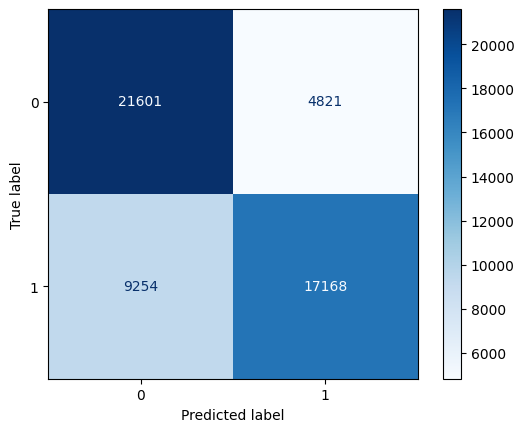

In [253]:
cm = confusion_matrix(Y_smote1, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [254]:
y_pred_test = neigh.predict(X_test1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test1, y_pred_test))
print("Recall: {}".format(recall_score(Y_test1,y_pred_test)))
print("Precisión: {}".format(precision_score(Y_test1,y_pred_test)))
print("Puntuación F1: {}".format(f1_score(Y_test1,y_pred_test)))

Exactitud: 0.45
Recall: 0.39548693586698336
Precisión: 0.5512104283054003
Puntuación F1: 0.4605411012187743


In [255]:
print(classification_report(Y_test1, y_pred_test))

              precision    recall  f1-score   support

           0       0.38      0.54      0.45      4677
           1       0.55      0.40      0.46      6736

    accuracy                           0.45     11413
   macro avg       0.47      0.47      0.45     11413
weighted avg       0.48      0.45      0.45     11413



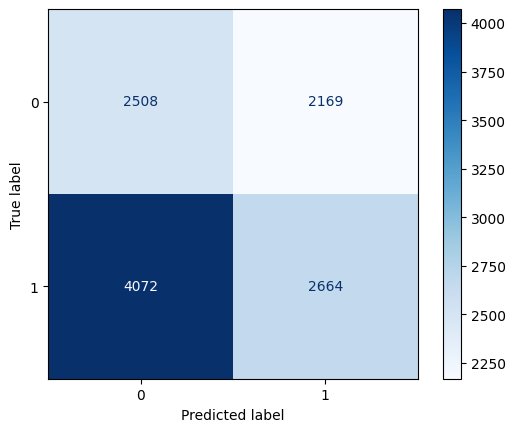

In [256]:
cm = confusion_matrix(Y_test1, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 4.1.2 Busqueda de mejores hiper parametros

In [257]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos a probar
    'weights': ['uniform', 'distance'],  # Pesos en la clasificación
    'metric': ['euclidean', 'manhattan']#, 'minkowski']  # Tipos de distancia
}

In [ ]:
neigh = KNeighborsClassifier()
particiones = KFold(n_splits=5, shuffle=True, random_state=0)
mejor_modelo = GridSearchCV(neigh, param_grid, cv=particiones)

mejor_modelo.fit(X_smote1_knn, Y_smote1)
mejor_modelo.best_params_

In [ ]:

# Obtener los mejores hiperparámetros encontrados
best_params = mejor_modelo.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Usar el mejor modelo encontrado
best_knn = mejor_modelo.best_estimator_

# Evaluar en los datos de prueba
y_pred_test = best_knn.predict(X_test1_knn)

print('Exactitud: %.2f' % accuracy_score(Y_test1, y_pred_test))
print("Recall:", recall_score(Y_test1, y_pred_test))
print("Precisión:", precision_score(Y_test1, y_pred_test))
print("Puntuación F1:", f1_score(Y_test1, y_pred_test))


Mejores hiperparámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Exactitud: 0.36
Recall: 0.015625
Precisión: 0.5
Puntuación F1: 0.030303030303030304


## 4.2 Arboles de decision

In [ ]:
## 